# A method to correct precipitation fields for ocean models.

*R. Dussin*

## 1. Regridding GPCP v2.3 to ERAinterim grid

The first step is to regrid the satelite-based precipitations onto the Atmospheric reanalyse grid. This can be done easily with xesmf.

In [1]:
import xarray as xr
import numpy as np

In [2]:
gpcpdir = '/Users/raphael/STORAGE/GPCP2.3/'
gpcp = xr.open_dataset(gpcpdir + 'precip.mon.mean.nc')

In [3]:
gpcp['precip']

<xarray.DataArray 'precip' (time: 482, lat: 72, lon: 144)>
[4997376 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon      (lon) float32 1.25 3.75 6.25 8.75 ... 351.25 353.75 356.25 358.75
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2019-02-01
Attributes:
    long_name:     Average Monthly Rate of Precipitation
    valid_range:   [  0. 100.]
    units:         mm/day
    precision:     32767
    var_desc:      Precipitation
    dataset:       GPCP Version 2.3 Combined Precipitation Dataset
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Mean
    actual_range:  [0.00000e+00 9.96921e+36]

In [4]:
import xesmf

In [5]:
erai_dir = '/Volumes/L4/ERAinterim/nc_daily/'

In [6]:
erai_grid = xr.open_dataset(f'{erai_dir}/precip_ERAinterim_1979_daily.nc', decode_times=False, drop_variables=['time', 'precip'])

In [7]:
erai_grid

<xarray.Dataset>
Dimensions:  (lat: 256, lon: 512)
Coordinates:
  * lat      (lat) float64 89.46 88.77 88.07 87.37 ... -88.07 -88.77 -89.46
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
Data variables:
    *empty*

Now let's add the cell edges:

In [8]:
# ERA-interim

lon = erai_grid['lon'].values
lon_bnds = np.concatenate((np.array([lon[0] -0.5 * 0.7031]), 0.5 * (lon[:-1] + lon[1:]), np.array([lon[-1] + 0.5 * 0.7031])), axis=0)

lat = erai_grid['lat'].values
lat_bnds = np.concatenate((np.array([90]), 0.5 * (lat[:-1] + lat[1:]), np.array([90])), axis=0)

erai_grid['lon_b'] = xr.DataArray(data=lon_bnds, dims=('lonp1'))
erai_grid['lat_b'] = xr.DataArray(data=lat_bnds, dims=('latp1'))

In [9]:
erai_grid

<xarray.Dataset>
Dimensions:  (lat: 256, latp1: 257, lon: 512, lonp1: 513)
Coordinates:
  * lat      (lat) float64 89.46 88.77 88.07 87.37 ... -88.07 -88.77 -89.46
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
Dimensions without coordinates: latp1, lonp1
Data variables:
    lon_b    (lonp1) float64 -0.3515 0.3516 1.055 1.758 ... 358.2 358.9 359.6
    lat_b    (latp1) float64 90.0 89.11 88.42 87.72 ... -88.42 -89.11 90.0

In [10]:
# GPCP

gpcp['lon_b'] = xr.DataArray(data=np.arange(0,360+2.5,2.5), dims=('lonp1'))
gpcp['lat_b'] = xr.DataArray(data=np.arange(-90,90+2.5,2.5), dims=('latp1'))

In [11]:
gpcp2erai = xesmf.Regridder(gpcp, erai_grid, 'conservative', periodic=True)

Overwrite existing file: conservative_72x144_256x512.nc 
 You can set reuse_weights=True to save computing time.


In [12]:
gpcp_precip_interp = gpcp2erai(gpcp['precip'])

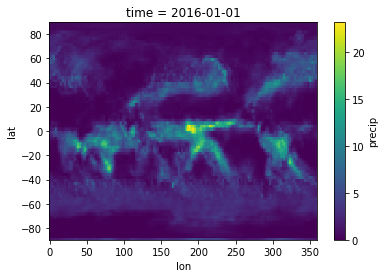

In [13]:
gpcp_precip_interp.sel(time='2016-1').plot()

In [34]:
gpcp_regridded = xr.Dataset()
gpcp_regridded['precip'] = gpcp_precip_interp
gpcp_regridded.to_netcdf('/Volumes/L4/GPCP_v2.3_256x512.nc')

## 2. Generate new dataset

### Functions

In [14]:
def cumul_precip(da):
    ''' apply cumsum and scale data array'''
    # create cumulated precip
    da_cs = da.cumsum(dim='time')
    # concat with zero initial value, needed for decumul
    zeroslice = xr.zeros_like(da_cs.isel(time=0))
    da_cs = xr.concat([zeroslice, da_cs], dim='time')
    return da_cs

def normalize_cumulated_precip(da):
    # normalize to the last value
    #print(da.isel(time=-1).min())
    norm = da.isel(time=-1).clip(min=1e-15)
    #print(norm.min().values)
    da_scaled = da / norm
    return da_scaled

def decumul_precip(da):
    out = da.diff('time')
    return out

### Method

* extract monthly data from ERAinterim yearly file
* cumul/scale the data and reserve
* conservative regridding of monthly GPCP onto ERAinterim grid
* total precip in GPCP = avg monthly value * ndays_in_month
* rescale the cumulative sum with GPCP value (smoothing required?)
* run decumulation

### Compute

In [30]:
def process_one_year(ds_erai, da_gpcp):
    current_year = ds_erai.time.dt.year[0].values
    print(current_year)
    ds_out = xr.zeros_like(ds_erai)
    for month in range(12):
        cmonth = str(month+1).zfill(2)
        data_month = ds_erai['precip'].sel(time=f'{current_year}-{cmonth}')
        ndays = len(data_month.time)
        #print(data_month.time)
        cumul = cumul_precip(data_month.clip(min=0))
        cumul_normed = normalize_cumulated_precip(cumul)
        new_total = da_gpcp.sel(time=f'{current_year}-{cmonth}').values.squeeze()
        new_total = new_total * ndays / 1000  # total precip in meters
        ny, nx = new_total.shape
        new_data_month = decumul_precip(cumul_normed.transpose(*('time', 'lat', 'lon')) * new_total) * 1000 / 86400 # kg.m-2.s-1
        if month == 0:
            da_out = new_data_month.copy()
        else:
            da_out = xr.concat([da_out, new_data_month], dim='time')
    ds_out['precip'] = da_out
    return ds_out

In [16]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()

In [17]:
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:58115 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 17.18 GB


In [33]:
outdir = '/Volumes/L4/ERAinterim/corrected_precips/'
encoding = {'time': {'_FillValue': 0}, 'lon': {'_FillValue': 1e+36},
            'lat': {'_FillValue': 1e+36}, 'precip': {'_FillValue': 1e+36}}

for year in np.arange(1979,2018+1):
    ds = xr.open_dataset(f'{erai_dir}/precip_ERAinterim_{year}_daily.nc')
    ds_time = xr.open_dataset(f'{erai_dir}/precip_ERAinterim_{year}_daily.nc', decode_times=False)
    ds_corrected = process_one_year(ds, gpcp_precip_interp)
    ds_corrected['time'] = ds_time['time']
    ds_corrected['precip'].attrs = {'valid_min': 0., 'valid_max': 1e-2}
    ds_corrected.to_netcdf(f'{outdir}/precip_Dussin_corrected_{year}_daily.nc', encoding=encoding)

1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
